In [6]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall, JLD2

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [7]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
;

# prep data

In [8]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

In [9]:
Random.seed!(0)
ntest = 5000
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, ntest);
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 5000 spectra, 0 need to be downloaded


In [5]:
#rf_obsids = CSV.read("./random.csv").obsid;
#Random.seed!(12345)
#rf_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, 30000);
#download_lamost_spectra(rf_obsids; verbose=false)
#
#rf_spectra = []
##rf_ivar = []
#bad_obsids = []
#for obsid in rf_obsids
#    try
#        wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
#        push!(rf_spectra, flux)
#        #push!(rf_ivar, ivar)
#    catch
#        println(obsid)
#        push!(bad_obsids, obsid)
#    end
#end
#rf_spectra = transpose(reduce(hcat, rf_spectra))
##rf_ivar = transpose(reduce(hcat, rf_ivar))
#;

In [6]:
#using JLD2, FileIO
#@save "random_30000_rf_spectra.jld2" rf_spectra rf_obsids

In [10]:
using JLD2, FileIO
@load "random_30000_rf_spectra.jld2"

2-element Array{Symbol,1}:
 :rf_spectra
 :rf_obsids 

In [11]:
include("lines_and_grid.jl")
#mask subordinate Li feature
rf_spectra = rf_spectra[:, .! subordinate_line_mask]
masksub(x) = x[.! subordinate_line_mask]
test_spectra = masksub.(test_spectra)
test_ivar = masksub.(test_ivar)
;

In [8]:
#whiten spectra
#typical_uncertainty = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#plot(wl_grid, typical_uncertainty)
#
#rf_spectra .-= 1
#rf_spectra ./= typical_uncertainty'
#rf_ivar .*= typical_uncertainty'.^2
#test_spectra = [(f .- 1)./typical_uncertainty for f in test_spectra]
#test_ivar = [iv .* typical_uncertainty.^2 for iv in test_ivar]
#;

# test one spectrum

  8.921150 seconds (29.09 M allocations: 1.981 GiB, 2.08% gc time)
 

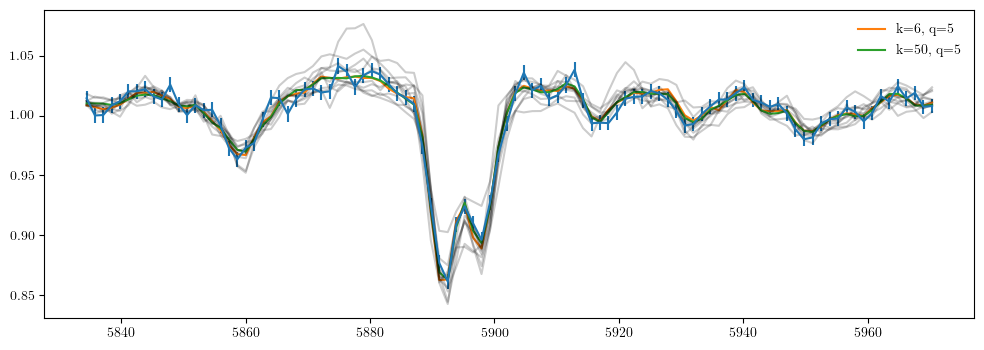

 1.467667 seconds (143 allocations: 731.066 MiB, 9.99% gc time)


PyObject <matplotlib.legend.Legend object at 0x13cd391d0>

In [6]:
include("model.jl")

maskfrac = 0.1
k = 10
q = 5

f, ivar = rand(collect(zip(test_spectra, test_ivar)))
mask = rand(size(rf_spectra, 2)) .< maskfrac


figure(figsize=(12, 4))
pltmask = 1750:1850
errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2))
@time pf = predict_spectral_range(f, ivar, rf_spectra, nothing, 200, 50, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=6, q=5")
@time pf = predict_spectral_range(f, ivar, rf_spectra, nothing, 1000, 50, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=50, q=5")

σ = ivar.^(-1/2)
σ[σ .== Inf] .= 1.
neighbors = find_neighbors(f[.! mask], rf_spectra[:, .! mask], k)
plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.2)
legend()

# show that error from unmasked pixels is subdominant

In [51]:
include("lines_and_grid.jl")
k = 500
q = 50

f, ivar = rand(collect(zip(test_spectra, test_ivar)))

neighbors = find_neighbors(f[.! line_mask], rf_spectra[:, .! line_mask], k)
F = rf_spectra[neighbors, :]
eivals, eivecs = eigen(F * F')
eispec = F' * eivecs[:, end-q+1:end]

invΣ = diagm(ivar[.! line_mask])                                                             
E = eispec[.! line_mask, :]
β = (E' * invΣ * E) \ (E' * invΣ * f[.! line_mask] )

eispec * β

mE = eispec[line_mask, :]

using LinearAlgebra
println((ivar[line_mask].^(-1/2)))
println(prod(ivar[line_mask].^(-1/2)))

#mE' * (E' * invΣ * E) \ mE
det(mE * ((E' * invΣ * E) \ mE'))

[0.011080829630960996, 0.010991543430313243, 0.011166578933305277, 0.01125070481772175, 0.011326597004326323, 0.011185861811892446, 0.010948055034994617, 0.011092873362331827, 0.011510801420467823]
2.7101062367393826e-18
2.7101062367393826e-18


0.0f0

# parameter study

In [153]:
include("model.jl")
function MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k, q)
    Random.seed!(2)
    
    MSE = map(collect(zip(test_spectra, test_ivar))[1:500]) do (f, ivar)
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        
        pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, k, q, mask)
        #dists = map(eachrow(rf_spectra)) do rf_spec                                                  
        #    sum((f[.! mask] .- rf_spec[.! mask]).^2 .* ivar[.! mask])
        #end 
        #dists = sum((rf_spectra[:, .! mask] .- f[.!mask]').^2, dims=2)[:] #.* ivar[.! mask]', dims=2)[:]
        #dists = sum((rf_spectra[:, .! mask] .- f[.!mask]').^2 .* ivar[.! mask]', dims=2)[:]
        #F = rf_spectra[partialsortperm(dists, 1:k), :]
        #pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #ivar = copy(ivar)
        #σ = ivar.^(-1/2)
        #σ[σ .== Inf] .= 1.
        #
        #neighbors = find_neighbors(f, σ, rf_spectra', zeros(size(rf_ivar')), k)
        #F = rf_spectra[neighbors, :] 
        #error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar[neighbors, :])];
        #pf = project_onto_local_manifold((F .- 1)./error', (f.-1)./error, ivar.*error.^2, mask, q) .* error .+ 1
        #pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #figure(figsize=(12, 4))
        #errorbar(wl_grid[mask], f[mask], yerr=ivar[mask].^(-1/2))
        #plot(wl_grid[mask],pf[mask])
        #plot(wl_grid[mask],F[:, mask]', c="k", alpha=0.1)
        #figure(figsize=(12, 3))
        #plot(wl_grid,f)
        #plot(wl_grid,pf)
        #plot(wl_grid,F', c="k", alpha=0.1)
        
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
#@time MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, 10, 5)

MSE (generic function with 1 method)

In [154]:
include("model.jl")
function MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k)
    Random.seed!(2)
    
    MSE = map(collect(zip(test_spectra, test_ivar))[1:500]) do (f, ivar)
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        neibs = find_neighbors(f, rf_spectra, k)
        pf = mean(rf_spectra[neibs, :], dims=1)
       
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
@time MSE(rf_spectra, nothing, test_spectra, test_ivar, 5)

663.484119 seconds (1.13 M allocations: 198.639 GiB, 2.41% gc time)


1.0770022f0

In [155]:
MSEss = []
meanMSEs = []
@time for k in [50, 100, 250, 500, 1000, 1500, 2000]
    println(k)
    qs = vcat([3, 6, 10, 20, 30, 40], collect(50:25:min(k-1, 150)))
    MSEs = [MSE(rf_spectra, nothing, test_spectra, test_ivar, k, q) for q in qs]
    push!(MSEss, MSEs)
    push!(meanMSEs, MSE(rf_spectra, nothing, test_spectra, test_ivar, k))
end

50
100
250
500
1000
1500
2000
72589.507254 seconds (7.95 M allocations: 30.987 TiB, 8.92% gc time)


In [174]:
for k in [1, 2, 3]
    println(k)
    println(MSE(rf_spectra, nothing, test_spectra, test_ivar, k))
    println()
end

1
1.3048532

2
1.1849784

3
1.1050667



In [156]:
meanMSEs

7-element Array{Any,1}:
 1.0666498f0
 1.0987995f0
 1.1598388f0
 1.2183656f0
 1.2968745f0
 1.3619871f0
 1.4162798f0

In [15]:
using Serialization
#serialize("MSEss.jdb", MSEss)
#serialize("meanMSEs.jdb", meanMSEs)
MSEss = deserialize("MSEss.jdb")
meanMSEs = deserialize("meanMSEs.jdb")
;

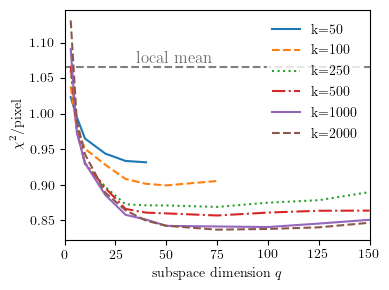

In [16]:
figure(figsize=(4, 3))
for (i, (k, MSEs, meanMSE, ls)) in enumerate(zip([50, 100, 250, 500, 1000, 1500, 2000], MSEss, meanMSEs, ["-", "--", ":", "-.", "-", "blah", "--"]))
    if k != 1500
        qs = vcat([3, 6, 10, 20, 30, 40], collect(50:25:min(k-1, 150)))
        plot(qs, MSEs, label="k=$k", ls=ls)
    end
end
xlim(0, 150)
text(35, minimum(meanMSEs) + 0.005, "local mean", size=12, c="k", alpha=0.6)
axhline(minimum(meanMSEs), c="k", ls="--", zorder=-1, alpha=0.5)
xlabel(L"subspace dimension $q$")
ylabel(L"\chi^2 / \mathrm{pixel}")
legend(frameon=true, edgecolor="w", facecolor="w")
tight_layout()
savefig("../../Desktop/MSEq.pdf")

# look at flagged stars

In [ ]:
df = FITS(DataFrame ∘ last, "random_30000_all_k1000.classified.fits");

In [60]:
df.flagged = (df.EEW_err .< 0.05) .& (df.EEW .> 0.15);

In [17]:
obs = Dict()
FITS("../cats/lamost-dr5-v3-stellar.fits.gz") do f
    for (obsid, designation) in zip(read(f[2], "obsid"), read(f[2], "designation"))
        if haskey(obs, designation)
            push!(obs[designation], obsid)
        else
            obs[designation] = [obsid]
        end
    end
end

In [21]:
include("model.jl")

model_comparison (generic function with 1 method)

star J091334.83+174542.9 was observed 3 times (Int32[117909147, 118009147, 200904103])
of 3 spectra, 0 need to be downloaded
best-fit chi2: 0.50725496, 0.94469184
best-fit chi2: 0.939736, 0.94469184
best-fit chi2: 0.52729905, 0.94469184


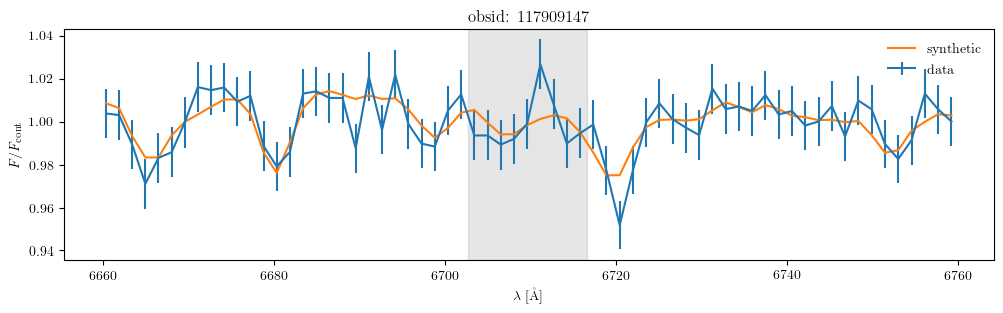

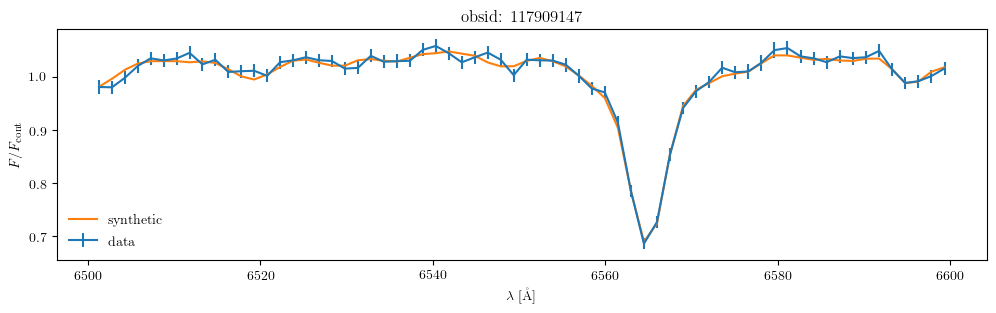

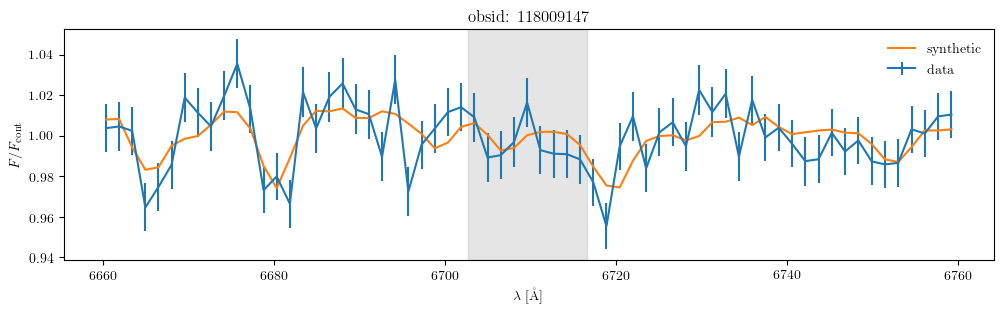

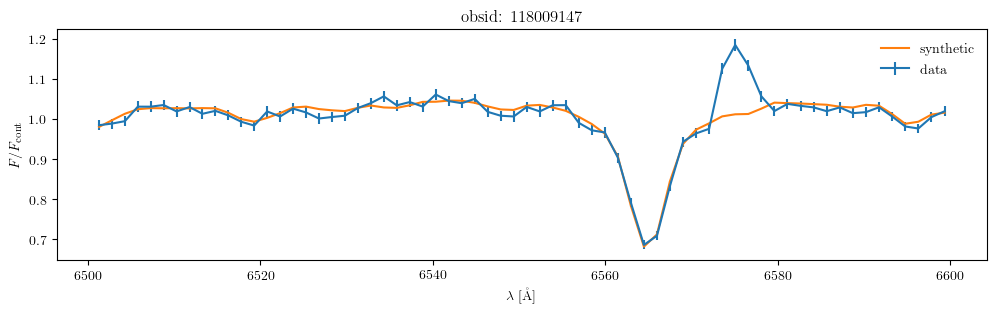

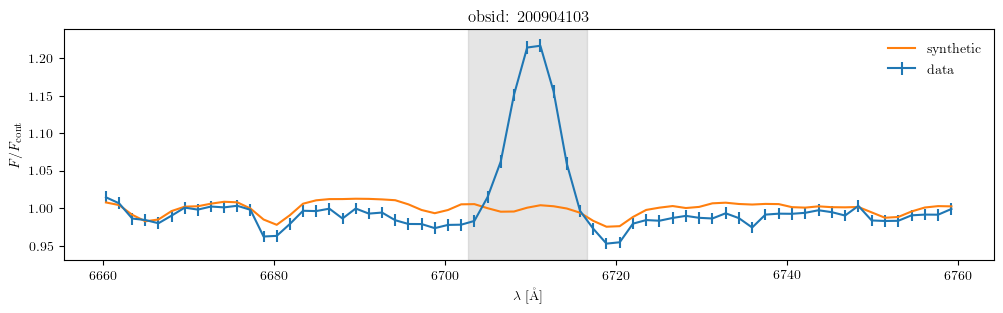

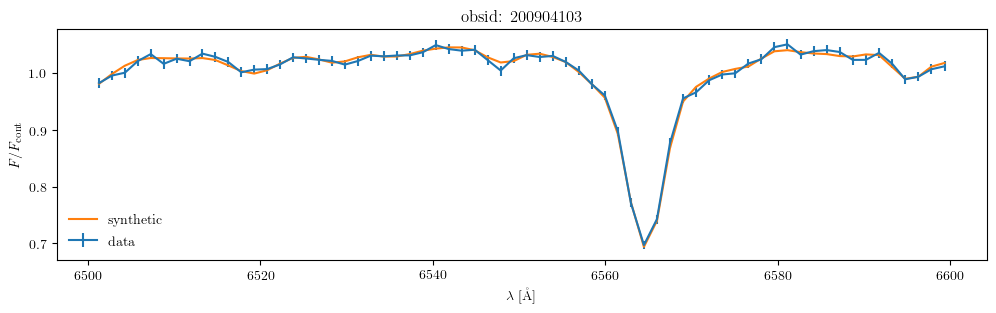

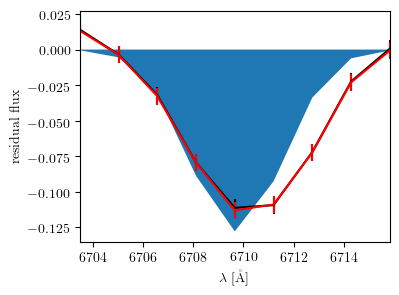

EEW: -0.5971077019155201 -0.6010097925780015
EEW_err: 0.018981335696165596 0.018981335696165596


In [75]:
#row = rand(eachrow(df[(df.EEW .< -.15) .& (df.EEW_err .< 0.05) .& df.isline, :]))

include("lines_and_grid.jl")
pltmask = li_vac - 50 .< wl_grid .< li_vac + 50

k = 1000
q = 50

obsids = obs[row.designation]
println("star $(row.designation) was observed $(length(obsids)) times ($obsids)")

residual_flux = []
residual_ivar = []

download_lamost_spectra(obsids; verbose=false)
for obsid in obsids
    wl, flux, ivar = load_lamost_spectrum(obsid;L=25, wl_grid=wl_grid)
    pf = predict_spectral_range(flux, ivar, rf_spectra, nothing, k, q, line_mask)
    
    best_fit_chi2 = sum((pf[.! line_mask] - flux[.! line_mask]).^2 .* ivar[.! line_mask])
    println("best-fit chi2: $(best_fit_chi2/length(wl)), $(row.max_best_fit_chi2/length(wl))")
    
    figure(figsize=(12, 3))
    title("obsid: $obsid")
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl_grid[pltmask], flux[pltmask], yerr=ivar[pltmask].^(-1/2), label="data")
    axvspan(li_vac - Δλ, li_vac + Δλ, alpha=0.2, color="gray")
    plt.plot(wl_grid[pltmask], pf[pltmask], label="synthetic")
    legend()
    
    #pmask = 6300 .< wl_grid .< 7000
    pmask = 6500 .< wl_grid .< 6600
    figure(figsize=(12, 3))
    title("obsid: $obsid")
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl_grid[pmask], flux[pmask], yerr=ivar[pmask].^(-1/2), label="data")
    plt.plot(wl_grid[pmask], pf[pmask], label="synthetic")
    legend()
    
    push!(residual_flux, - flux[line_mask] + pf[line_mask])
    push!(residual_ivar, ivar[line_mask])
end
rivar = sum(residual_ivar)
rflux = sum([p.*r for (p,r) in zip(residual_ivar, residual_flux)]) ./ rivar

M = model_matrix(wl_grid[line_mask], li_vac, li_vac/3600)
invΣ = Diagonal(rivar)
l1 = diag(M * invΣ * M')
l2 = M * invΣ * rflux
loss = @. -l2^2 / l1

isline = argmin(loss) == 1
EEW = l2./l1
EEW_err = 1/sqrt(l1[1]) 

#errorbar(wl_grid[line_mask], rflux, yerr = rivar.^(-1/2))
figure(figsize=(4,3))
errorbar(wl_grid[line_mask], rflux, yerr=rivar.^(-1/2), c="k")
errorbar(wl_grid[line_mask], row.diff, row.ivar.^(-1/2), c="r")
#plot(wl_grid[line_mask], pf[line_mask], lw=3)
fill_between(wl_grid[line_mask], 0, M[1, :]*EEW[1])
xlabel(L"$\lambda$ [\AA]"); ylabel("residual flux"); 
xlim(wl_grid[line_mask][1], wl_grid[line_mask][end])
println("EEW: ", EEW[1], " ", row.EEW)
println("EEW_err: ", EEW_err, " ", row.EEW_err)

In [150]:
include("air_vacuum.jl")
vac_to_air(6708.5)

6706.648334545525

# test Li outliers with large $k, q$

In [7]:
#using CSV
#outliers = CSV.read("distributed_topsnr_1000_test.flagged.csv");

In [124]:
#download_lamost_spectra(outliers.obsid)
#
#outlier_spectra = []
#outlier_ivar = []
#for obsid in outliers.obsid
#    wl, flux, ivar = load_lamost_spectrum(obsid; clip=false)
#    push!(outlier_spectra, flux)
#    push!(outlier_ivar, ivar)
#end
#;

of 760 spectra, 0 need to be downloaded


In [12]:
Δλ = 7
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ;

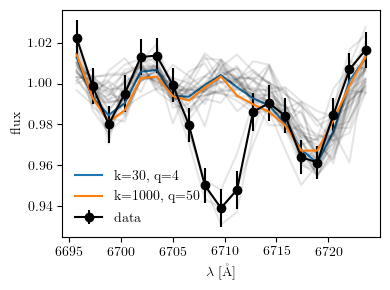

In [20]:
figure(figsize=(4, 3))

k, q = 30, 4
wl, f, ivar = load_lamost_spectrum(191906235, L=25, wl_grid=wl_grid)
pf = predict_spectral_range(f, ivar, rf_spectra, nothing, k, q, line_mask)
pltmask = li_vac-15 .< wl_grid .<  li_vac + 15
errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2), label="data", c="k", marker="o")
plot(wl_grid[pltmask], pf[pltmask], label="k=30, q=4")

neighbors = find_neighbors(f[.! line_mask], rf_spectra[:, .! line_mask], k)
plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.1)

pf = predict_spectral_range(f, ivar, rf_spectra, nothing, 100, 60, line_mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=1000, q=50")
legend()

xlabel(L"$\lambda$ [\AA]")
ylabel("flux")
tight_layout()
savefig("../../Desktop/hiqloq.pdf", bbox_inches="tight")

# $H_\alpha$ 

In [116]:
include("lines_and_grid.jl")
k = 1000
q = 50
halphamask = 6550 .< wl_grid .< 6580;
EEWs = map(eachrow(df[df.flagged, :])) do row
    obsids = obs[row.designation]

    residual_flux = []
    residual_ivar = []
    download_lamost_spectra(obsids; verbose=false)
    EEWs = map(obsids) do obsid
        wl, flux, ivar = load_lamost_spectrum(obsid;L=25, wl_grid=wl_grid)
        pf = predict_spectral_range(flux, ivar, rf_spectra, nothing, k, q, halphamask)
        sum(pf[halphamask] - flux[halphamask])
    end
    mean(EEWs)
end

of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 2 spectra, 2 need to be downloaded
of 6 spectra, 6 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 3 spectra, 3 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 2 spectra, 2 need to be downloaded
of 2 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 2 spectra, 2 need to be downloaded
of 2 spectra, 2 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra, 1 need to be downloaded
of 1 spectra

8140-element Array{Float32,1}:
  0.12551272 
 -0.045264065
  0.29964364 
  0.04451239 
  0.054995716
 -0.07753879 
  0.020586133
 -0.1424706  
 -0.06423491 
  0.003210485
  0.10078615 
  0.09677714 
  0.04042232 
  ⋮          
 -0.08178729 
  0.033269286
 -0.14532441 
 -0.040135324
  0.013584435
  0.027783334
 -0.025829554
  0.04663962 
 -0.03267467 
  0.044510543
  0.027813435
  0.045773625

In [118]:
lamost = FITS(DataFrame ∘ last, "../cats/LAMOST-dr5-v3-stellar.fits.gz")
flagged = join(df[df.flagged, :], lamost, on=:designation, kind=:left);
cols = [:teff, :logg, :EEW, :EEW_err]
flagged = combine(groupby(flagged, :designation), cols.=>mean);
rename!(flagged, (@. Symbol(String(cols)*"_mean") => cols)...);

,designation,teff,logg,EEW,EEW_err
,String,Float32,Float32,Float64,Float64
1,J221452.75-002151.5,6185.11,4.027,0.17347,0.0398651
2,J220912.95+015529.6,6105.62,4.158,0.173314,0.0345411
3,J004238.42+411921.7,4735.04,3.128,0.152701,0.0486756
4,J220714.26+303212.9,4559.61,4.65,0.194728,0.0490207
5,J220438.07+301240.4,4785.75,4.598,0.179161,0.0214365
6,J220959.11+302333.4,5715.69,3.966,0.195209,0.0462733
7,J220747.06+294829.3,5704.46,4.045,0.185525,0.0449824
8,J220932.98+294825.6,4827.4,1.873,0.18617,0.0410674
9,J221039.61+294728.8,4857.82,1.949,0.168651,0.0296447


In [137]:
using Serialization
serialize("flagged_Halpha.jdb", flagged)

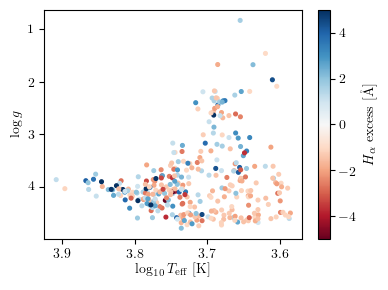

In [136]:
figure(figsize=(4, 3))
mask = (abs.(EEWs) .> 1) 
plt.scatter(log10.(flagged.teff[mask]), flagged.logg[mask], c=EEWs[mask], cmap="RdBu", vmin=-5, vmax=5, s=7)
colorbar(label=L"$H_\alpha$ excess [\AA]")
gca().invert_yaxis()
gca().invert_xaxis()
xlabel(L"$\log_{10} T_\mathrm{eff}$ [K]")
ylabel(L"\log g")
tight_layout()
savefig("../../Desktop/Halphakiel.pdf", bbox_inches="tight");

In [ ]:
pleiades